In [1]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
train_df = pd.read_csv("../data/train.csv",low_memory=False)
test_df = pd.read_csv("../data/test.csv",low_memory=False)
store_df = pd.read_csv("../data/store.csv",low_memory=False)

Store Sales dataset into time series data

In [52]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
data = train_df[['Date', 'Store', 'Sales']]

# Filter for a specific store (e.g., Store 1)
store_data = data[data['Store'] == 1]
store_data.set_index('Date', inplace=True)
store_data = store_data.resample('D').sum()

Series Data is Stationary

In [54]:
# Check stationarity for a specific store
# Perform the ADF test

check_stationarity(store_data['Sales'])

ADF Statistic: -4.3681043682
p-value: 0.0003378835
Critical Values:
	1%: -3.4374778690
	5%: -2.8646866842
	10%: -2.5684454927
The time series is stationary


Check for autocorrelation and partial autocorrelation of your data

In [55]:
# Difference the series (store_data is a Series, no need to reference 'Sales')
adf_result = adfuller(store_data['Sales'])
if adf_result[1] >= 0.05:
    store_data['Sales'] = store_data['Sales'].diff().dropna()

autocorrelation and partial autocorrelation of your data

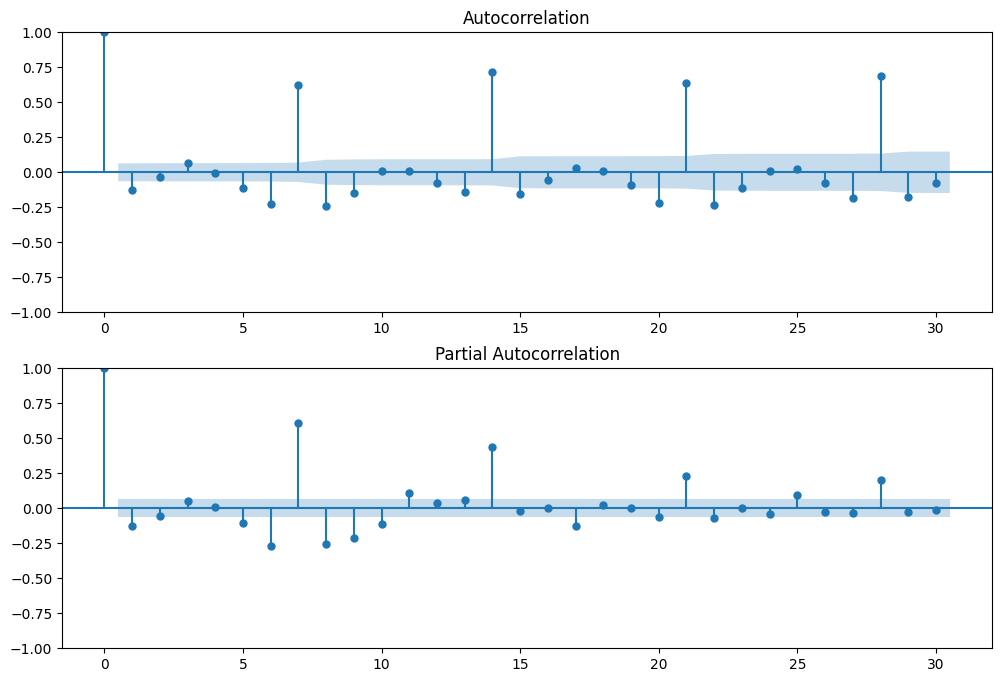

In [56]:
# Autocorrelation and Partial Autocorrelation plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(store_data['Sales'].dropna(), lags=30, ax=ax[0])
plot_pacf(store_data['Sales'].dropna(), lags=30, ax=ax[1])
plt.show()

Transform the time series data into supervised learning data

In [57]:
# Define time steps
n_step = 30   # number of steps to use for prediction (30 days)
data_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(store_data['Sales'].values.reshape(-1, 1))
X, y = create_supervised_data(data_scaled, n_step)

# Reshape input to be [samples, n_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

 Scale your data in the (-1, 1) range

In [58]:
# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(store_data['Sales'].values.reshape(-1, 1))

# Create dataset for LSTM
X, y = create_supervised_data(data_scaled, n_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

Build an LSTM Regression model to predict the next sale

In [59]:
# Build and train the LSTM model
model = build_lstm_model(n_step)

In [60]:
### Train the model
history = train_lstm_model(model, X, y)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - loss: 0.2118 - val_loss: 0.1578
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.1910 - val_loss: 0.1619
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.1681 - val_loss: 0.1554
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.1859 - val_loss: 0.1558
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.1830 - val_loss: 0.1561
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.1840 - val_loss: 0.1527
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.1743 - val_loss: 0.1568
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.1769 - val_loss: 0.1520
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.1777 - val_loss: 0.1519
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.1809 - val_loss: 0.1496
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.1776 - val_loss: 0.1546
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/ste

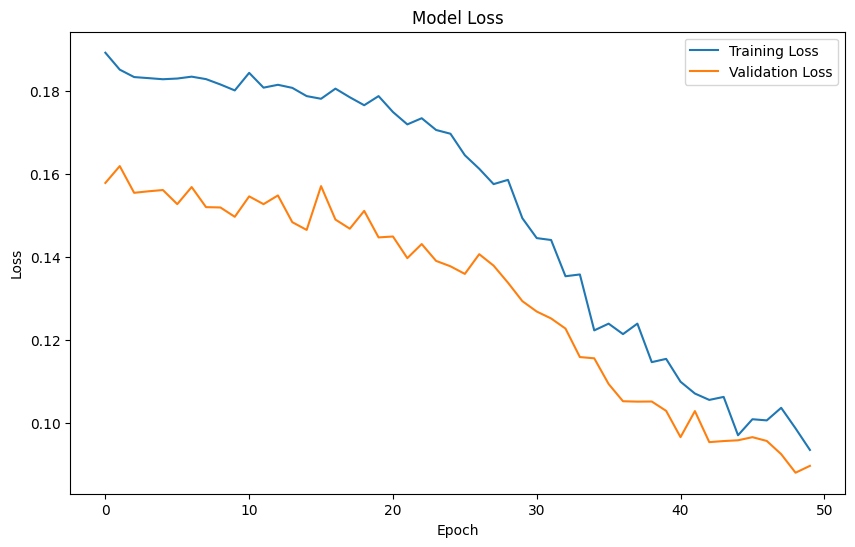

In [75]:
"""Plot training and validation loss."""
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [76]:
# Make predictions
predicted_sales = model.predict(X)

# Inverse transform to get actual sales values
predicted_sales = scaler.inverse_transform(predicted_sales.reshape(-1, 1))

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step


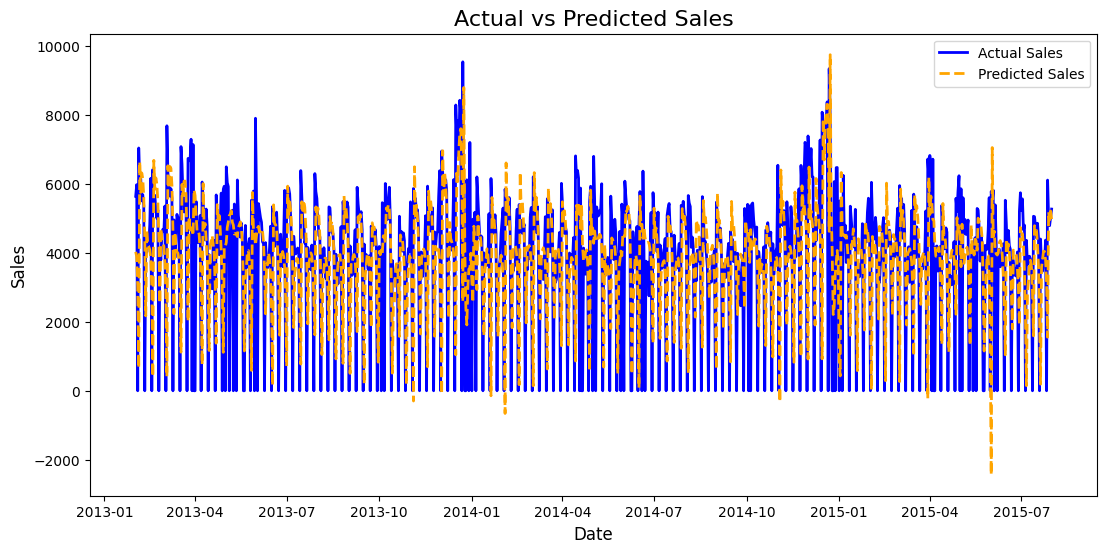

In [77]:
# Plot the the actual vs predicted results
plt.figure(figsize=(13, 6))
plt.plot(store_data.index[n_step+1:], store_data['Sales'][n_step+1:], 
         label='Actual Sales', color='blue', linestyle='-', linewidth=2)

# Plot the predicted sales
plt.plot(store_data.index[n_step+1:], predicted_sales, 
         label='Predicted Sales', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.show()

In [78]:
# Calculate evaluation metrics
mse = mean_squared_error(store_data['Sales'][n_step+1:], predicted_sales)
mae = mean_absolute_error(store_data['Sales'][n_step+1:], predicted_sales)
rmse = np.sqrt(mse)
#r2=r2_score(store_data['Sales'][n_step+1:], predicted_sales)
#msle=mean_squared_log_error(store_data['Sales'][n_step+1:], predicted_sales)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 4919671.904581162
Mean Absolute Error (MAE): 1529.2193296078663
Mean Squared Error (RMSE): 2218.0333416297335
